In [21]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from skimage.util import view_as_blocks
from skimage.transform import resize
from sklearn.cluster import KMeans
import torch
import torchvision.transforms as T
from torchvision.models import resnet18
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import cv2
from matplotlib import cm


In [17]:
##reading the folder path and setting the Patch_size, number of cluster and batch Size
tiff_img_path = "/Users/suparnac/dev_envs/CV_Projects/Digantara"
patch_size = 32 #32x32 small blocks of images
number_clusters = 4 #k=4
batch_size = 32 #processing 32 patches/blocks together


In [4]:
##Considering ResNet 18 Model
resnet = resnet18(pretrained=True) #ResNet-18 is a pretrained model (on a ImageNet)
resnet.fc = torch.nn.Identity()  #Replaces ResNet's FC layer with an Identity function. This effectively turns ResNet-18 into a Feature Extractor
resnet.eval() #Inference mode (freezes training behaviours) 

#transform raw image patches to match resent's input requirements
transform = T.Compose([
    T.ToPILImage(), #converts numpy array into a Torch tensor(PIL img)
    T.Resize((224, 224)), #resizes path to a 224x224 pixels (std. input gfor the Resnet18)
    T.ToTensor(), #converts PIL img back to the Tensor value (pixel value [0,1])
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #Normalizing each color channel using mean and SD imporves model stability and performance by standardizing the input distribution
])


In [5]:
# Normalizing the img
def normalize(image):
    image = image.astype(np.float32) #unit8 to float32
    return (image - image.min()) / (image.max() - image.min()) #Normalization formula



In [6]:
def extract_patches(image, patch_size):

    """ 
    Extracts non-overlapping square patches from a 3D image tensor (C, H, W). 
    Crops the image if needed to ensure full patches, then reshapes the result into a list of patches of shape (N, C, patch_size, patch_size).
    Returns the patches along with the cropped height and width.
    """

    _, h, w = image.shape #_ is ignoring the channel dimention, not resizing or modifying the channel
    
    #ensures image can be clearly divided into equal patch_size
    h_cropped = h - (h % patch_size) 
    w_cropped = w - (w % patch_size)

    #crops image based on h-cropped and w-cropped
    cropped = image[:, :h_cropped, :w_cropped]

    #view_as_blocks() is a fucntion from scikit image that makes sure that the above "cropped" patches/images dont overlap eachother
    blocks = view_as_blocks(cropped, block_shape=(image.shape[0], patch_size, patch_size))

    #returns the cropped height and width for later reconstruction
    return blocks.reshape(-1, image.shape[0], patch_size, patch_size), h_cropped, w_cropped



In [12]:
def extract_resnet_features_batch(patches, batch_size=batch_size):

    """
    Extracts feature vectors from image patches using a pretrained ResNet model.

    - Each patch is first converted to a proper image format (HWC, uint8).
    - The defined transform (resize to 224×224, convert to tensor, normalize) is applied here.
      Note: The transform was defined earlier but is applied inside this function, because the raw patches entering this function are still in their original size (e.g., 32×32).
      ResNet requires inputs of size 224×224 with ImageNet type normalization.
    - Patches are processed in batches (defined by batch_size in the beginning) to speed up computation.
    - ResNet is used in evaluation mode to extract 512-dimensional feature vectors from each patch.
    - All features are returned as a NumPy array.
    """


    features = [] # initializing empty list "features" to store the feature vector
    batch = [] #initializing empty list "batch" that temp. stores a batch of transformed image patches

    #takes each 32x32, 3 channeled pixel and preprocess it, extract a 512-D feature vectore usinf ResNet
    for i, patch in enumerate(patches):
        patch_img = (patch * 255).astype(np.uint8).transpose(1, 2, 0) #transpose here changes (C, H, W) → (H, W, C) (needed for image libraries like PIL)
        input_tensor = transform(patch_img) #calls the earlier defined transform function
        batch.append(input_tensor) 

        if len(batch) == batch_size or i == len(patches) - 1: # Process the batch if it's full or if it's the last patch
            input_batch = torch.stack(batch)
            with torch.no_grad(): #Runs code block without gradient tracking
                feats = resnet(input_batch).cpu().numpy()
            features.extend(feats)
            batch = [] 
    return np.array(features) #features are returned ad an numpy array



In [10]:
##Load .tif or .tiff files
image_paths = []
for f in os.listdir(tiff_img_path):
    if f.endswith((".tif", ".tiff")):
        image_paths.append(os.path.join(tiff_img_path, f))



 Processing: /Users/suparnac/dev_envs/CV_Projects/Digantara/1_2.tif
Shape: (3, 8989, 14804)
TIFF Info:
Width: 14804
Height: 8989
Number of Bands: 3
Coordinate Reference System (CRS): EPSG:4326
Transform (Affine): | 0.00, 0.00, 77.44|
| 0.00,-0.00, 8.11|
| 0.00, 0.00, 1.00|
Driver: GTiff
Dtype:('uint8', 'uint8', 'uint8')
Bounds: BoundingBox(left=77.435225578, bottom=8.093500814, right=77.455078784, top=8.105555757)
Metadata: {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 14804, 'height': 8989, 'count': 3, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(1.3410703863816134e-06, 0.0, 77.435225578,
       0.0, -1.3410772054732434e-06, 8.105555757)}
Missing Data: None
Total patches

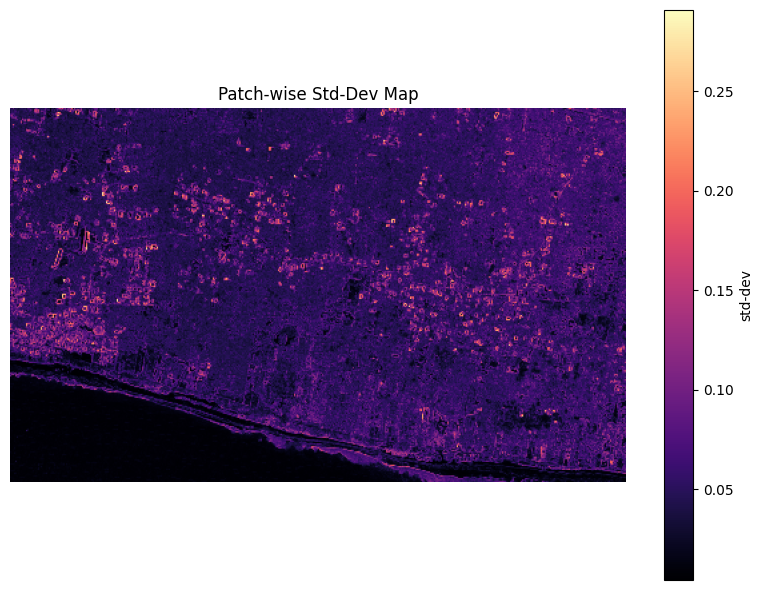

ResNet feature shape: (129360, 512)
Combined feature shape (with std-dev): (129360, 513)
Silhouette Score: 0.24726714193820953
Calinski-Harabasz Score: 46083.29979218367
Davies-Bouldin Score: 1.6407378377950699
Saved cluster map to: /Users/suparnac/dev_envs/CV_Projects/Digantara/resnet_cluster_maps/1_2_clusters.png


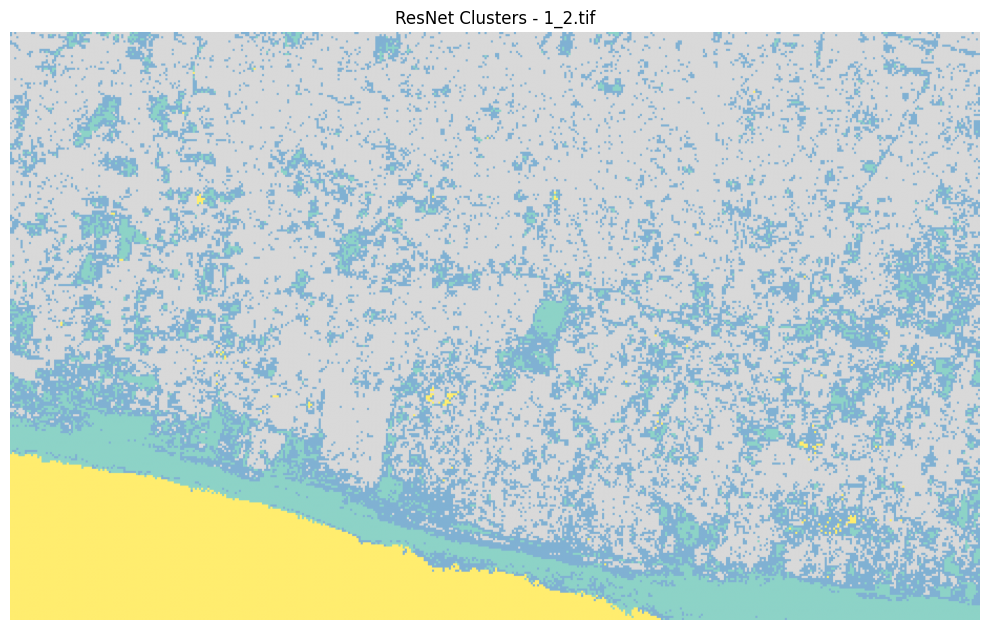


 Processing: /Users/suparnac/dev_envs/CV_Projects/Digantara/1_3.tif
Shape: (3, 10208, 14727)
TIFF Info:
Width: 14727
Height: 10208
Number of Bands: 3
Coordinate Reference System (CRS): EPSG:4326
Transform (Affine): | 0.00, 0.00, 77.46|
| 0.00,-0.00, 8.12|
| 0.00, 0.00, 1.00|
Driver: GTiff
Dtype:('uint8', 'uint8', 'uint8')
Bounds: BoundingBox(left=77.455078784, bottom=8.105555757, right=77.474828583, top=8.119246351)
Metadata: {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 14727, 'height': 10208, 'count': 3, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(1.3410605690235737e-06, 0.0, 77.455078784,
       0.0, -1.3411632053291373e-06, 8.119246351)}
Missing Data: None
Total patc

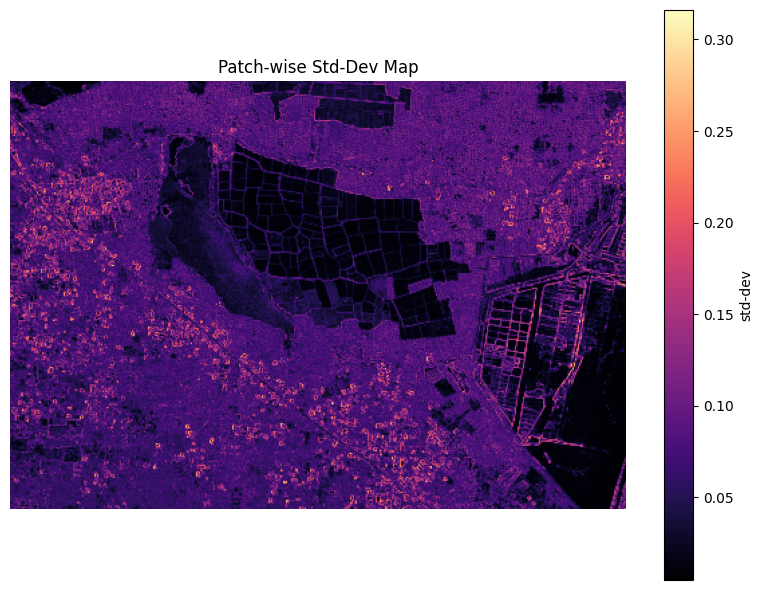

ResNet feature shape: (146740, 512)
Combined feature shape (with std-dev): (146740, 513)
Silhouette Score: 0.21631331741809845
Calinski-Harabasz Score: 39595.356952686576
Davies-Bouldin Score: 1.8181842203818797
Saved cluster map to: /Users/suparnac/dev_envs/CV_Projects/Digantara/resnet_cluster_maps/1_3_clusters.png


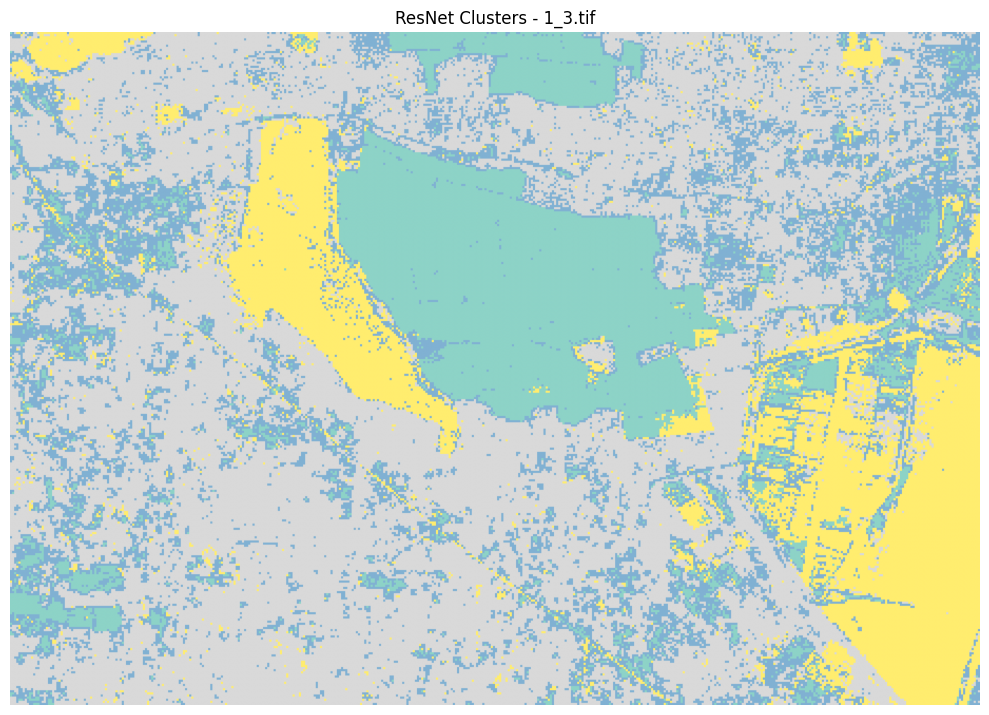


 Processing: /Users/suparnac/dev_envs/CV_Projects/Digantara/1_1.tif
Shape: (3, 10208, 14804)
TIFF Info:
Width: 14804
Height: 10208
Number of Bands: 3
Coordinate Reference System (CRS): EPSG:4326
Transform (Affine): | 0.00, 0.00, 77.44|
| 0.00,-0.00, 8.12|
| 0.00, 0.00, 1.00|
Driver: GTiff
Dtype:('uint8', 'uint8', 'uint8')
Bounds: BoundingBox(left=77.435225578, bottom=8.105555757, right=77.455078784, top=8.119246351)
Metadata: {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 14804, 'height': 10208, 'count': 3, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(1.3410703863816134e-06, 0.0, 77.435225578,
       0.0, -1.3411632053291373e-06, 8.119246351)}
Missing Data: None
Total patc

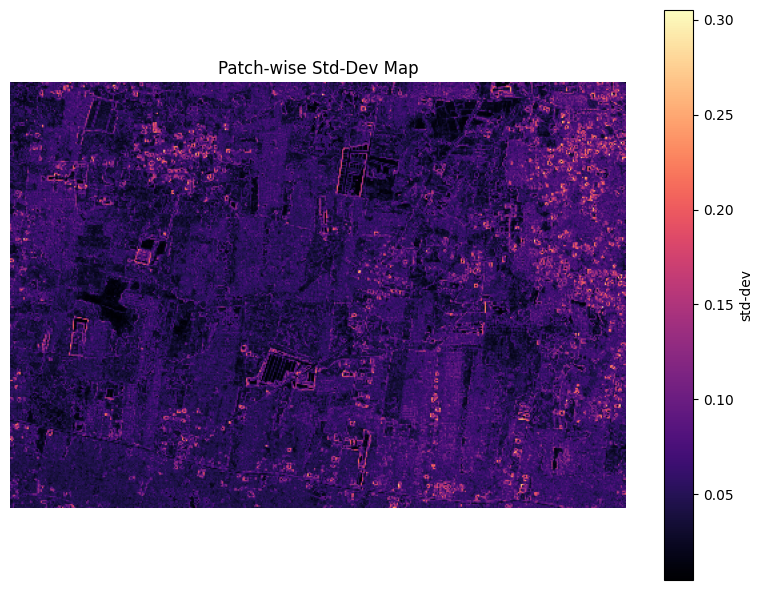

ResNet feature shape: (147378, 512)
Combined feature shape (with std-dev): (147378, 513)
Silhouette Score: 0.12903422117233276
Calinski-Harabasz Score: 38961.32707318647
Davies-Bouldin Score: 2.1447816519114657
Saved cluster map to: /Users/suparnac/dev_envs/CV_Projects/Digantara/resnet_cluster_maps/1_1_clusters.png


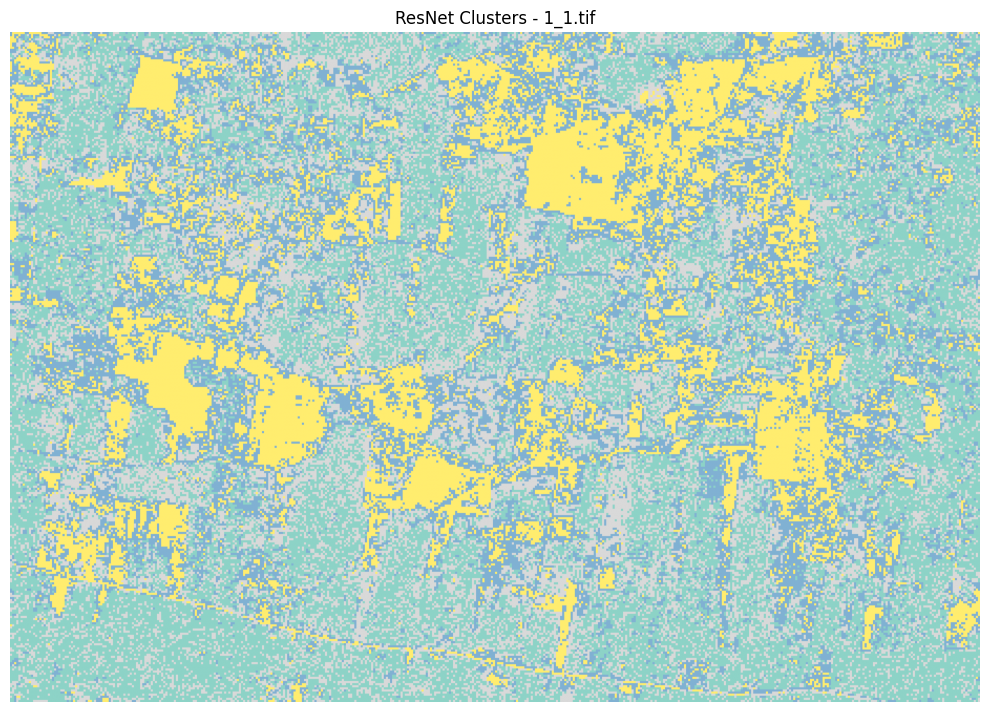

In [18]:
##Main loop/block

"""
MAIN PROCESSING LOOP

This loop iterates over each .tif or .tiff image in the dataset/path and performs the following steps:

1. Loads the image using Rasterio and prints key metadata.
2. Normalizes the image pixel values to the [0, 1] range.
3. Extracts non-overlapping patches of size (32x32).
4. Computes a patch-wise standard deviation map to analyze local texture variation.
5. Applies a pretrained ResNet model to extract 512-dimensional deep feature vectors for each patch.
6. Clusters these feature vectors using KMeans into a fixed number of semantic groups.
7. Reshapes and resizes the cluster labels to form a spatial map of patch categories.
8. Saves the cluster map as a color-coded image file.
9. Displays both the standard deviation heatmap and the final clustered output.

This pipeline effectively turns large satellite images into smaller interpretable units,
extracts high-level visual features from each, and groups them into semantically meaningful regions.
"""

for img_path in image_paths:
    with rasterio.open(img_path) as src:

        #Read image and check/print metadata of the .tif img
        image = src.read()

        print(f"\n Processing: {img_path}")
        print(f"Shape: {image.shape}")
        print("TIFF Info:")
        print(f"Width: {src.width}")
        print(f"Height: {src.height}")
        print(f"Number of Bands: {src.count}")
        print(f"Coordinate Reference System (CRS): {src.crs}")
        print(f"Transform (Affine): {src.transform}")
        print(f"Driver: {src.driver}")
        print(f"Dtype:{src.dtypes}")
        print(f"Bounds: {src.bounds}")
        print(f"Metadata: {src.meta}")
        print(f"Missing Data: {src.nodata}")
        
        #Calling pre-defined function Normalize and extract_patches
        norm_img = normalize(image) 
        patches, h_cropped, w_cropped = extract_patches(norm_img, patch_size)
        print(f"Total patches: {len(patches)}")

        #Standard Deviation Map
        std_map = np.array([np.mean(np.std(patch, axis=(1, 2))) for patch in patches]) #calculates standard deviation for each channel seperately, accross all pixels (axis 1- height , Axis 2- width, here, 32x32)
        ##Calculates how many patches there are vertically and horizontally
        h_blocks = h_cropped // patch_size
        w_blocks = w_cropped // patch_size
        std_map_reshaped = std_map.reshape(h_blocks, w_blocks)

        #plot standard deviation map
        plt.figure(figsize=(8, 6))
        plt.imshow(std_map_reshaped, cmap='magma')
        plt.title("Patch-wise Std-Dev Map")
        plt.colorbar(label='std-dev')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

        # Deep feature extraction
        features = extract_resnet_features_batch(patches, batch_size=batch_size) #calling pre-defined "extract_resnet_features_batch" function
        print(f"ResNet feature shape: {features.shape}")

        # Feature engineering ---- adding our standard deviation map vector as 513th feature of ResNet18
        '''
        This block adds the standard deviation of each patch as an extra (513th) feature to the 512-dimensional ResNet feature vector. 
        This combines both deep visual features and handcrafted texture information, improving the clustering quality.
        '''
        std_map = std_map.reshape(-1, 1)  # reshape to (num_patches, 1)
        features = np.hstack((features, std_map))  # final shape: (num_patches, 513)
        print("Combined feature shape (with std-dev):", features.shape)

        #performs KMeans Clustering on the 513-D feature vector and group them into 4 clusters
        kmeans = KMeans(n_clusters=number_clusters, random_state=42)
        labels = kmeans.fit_predict(features)
        
        #The flat labels are reshaped into a 2D grid matching the patch layout, then resized to the cropped image size for visualization and saving.
        label_map = labels.reshape(h_blocks, w_blocks)
        label_map_resized = resize(label_map, (h_cropped, w_cropped), order=0, preserve_range=True)

        #Evaluation: 
        #Silhourtte Score
        print("Silhouette Score:", silhouette_score(features, labels))
        print("Calinski-Harabasz Score:", calinski_harabasz_score(features, labels))
        print("Davies-Bouldin Score:", davies_bouldin_score(features, labels))

        

        
        #Save the output maps
        '''This block saves the final cluster map as a .png image. 
        It creates an output directory if it doesn't exist, constructs a filename based on the input image, 
        and saves the resized label map using a colormap for easy visualization.
        '''
        output_dir = os.path.join(tiff_img_path, "resnet_cluster_maps")
        os.makedirs(output_dir, exist_ok=True)

        output_filename = os.path.splitext(os.path.basename(img_path))[0] + "_clusters.png"
        output_path = os.path.join(output_dir, output_filename)

        plt.imsave(output_path, label_map_resized, cmap='Set3', vmin=0, vmax=number_clusters - 1)
        print(f"Saved cluster map to: {output_path}")

        
        #Visualization
        plt.figure(figsize=(10, 10))
        plt.imshow(label_map_resized, cmap='Set3', vmin=0, vmax=number_clusters - 1)
        plt.title(f"ResNet Clusters - {os.path.basename(img_path)}")
        plt.axis('off')
        plt.tight_layout()
        plt.show()


Processing overlay for: 1_2
Overlay saved to: /Users/suparnac/dev_envs/CV_Projects/Digantara/resnet_cluster_maps/1_2_overlay.png
Processing overlay for: 1_3
Overlay saved to: /Users/suparnac/dev_envs/CV_Projects/Digantara/resnet_cluster_maps/1_3_overlay.png
Processing overlay for: 1_1
Overlay saved to: /Users/suparnac/dev_envs/CV_Projects/Digantara/resnet_cluster_maps/1_1_overlay.png


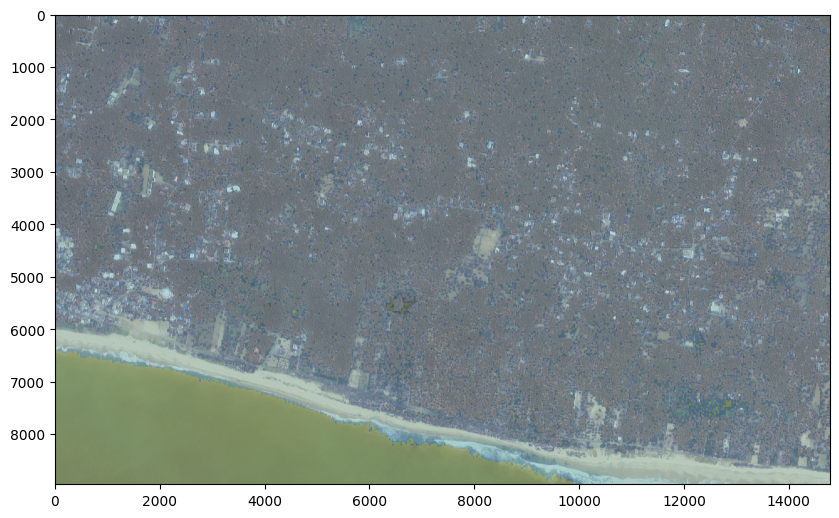

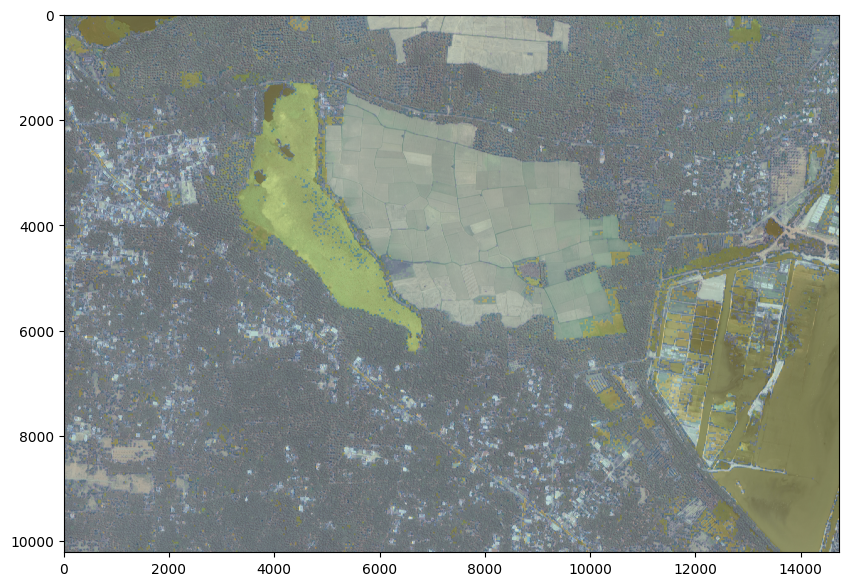

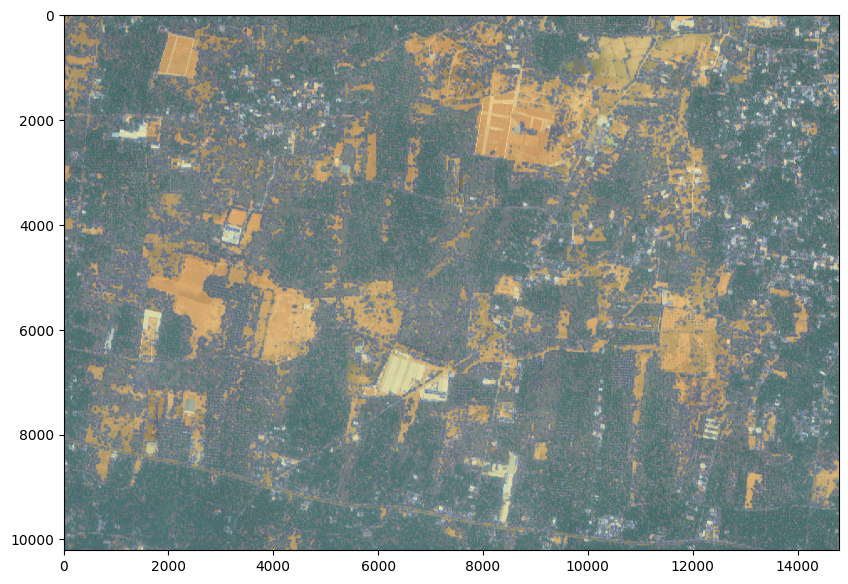

In [20]:
##Overlay Image Visualization

# Paths
input_folder = tiff_img_path
output_folder =  "/Users/suparnac/dev_envs/CV_Projects/Digantara/resnet_cluster_maps"
number_clusters = 4  # same as earlier

# Loop over saved cluster maps
for filename in os.listdir(output_folder):
    if filename.endswith("_clusters.png"):
        base_name = filename.replace("_clusters.png", "")
        cluster_map_path = os.path.join(output_folder, filename)
        original_img_path = os.path.join(input_folder, base_name + ".tif")

        print(f"Processing overlay for: {base_name}")

        # Load the original TIFF image
        with rasterio.open(original_img_path) as src:
            image = src.read()
            image = image[:, :image.shape[1] - (image.shape[1] % patch_size),
                             :image.shape[2] - (image.shape[2] % patch_size)]
            image = (image.astype(np.float32) / 255.0).clip(0, 1)
            image_rgb = (image.transpose(1, 2, 0) * 255).astype(np.uint8)

        # Load the saved cluster map
        cluster_map = plt.imread(cluster_map_path)
        if cluster_map.ndim == 2:  
            cmap = cm.get_cmap('Set3', number_clusters)
            cluster_map_colored = cmap(cluster_map / (number_clusters - 1))[:, :, :3]
        else:
            cluster_map_colored = cluster_map[:, :, :3]

        cluster_map_resized = resize(cluster_map_colored, (image_rgb.shape[0], image_rgb.shape[1]), preserve_range=True)
        cluster_map_rgb = (cluster_map_resized * 255).astype(np.uint8)

        # Blend using OpenCV
        overlay = cv2.addWeighted(image_rgb, 0.6, cluster_map_rgb, 0.4, 0)

        # Show
        plt.figure(figsize=(10, 10))
        plt.imshow(overlay)

        # Save the overlay image
        overlay_output_path = os.path.join(output_folder, base_name + "_overlay.png")
        cv2.imwrite(overlay_output_path, cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
        print(f"Overlay saved to: {overlay_output_path}")
